# What is Spark?

Spark is a data analytics platform for large data. Spark can work on Hadoop (a distributed file system and computing system).  The image of each spark worker node and spark head node can be seen below. Spark really shines when working with very large datasets (usually GBs or more).  The magic of Spark is its resilient distributed datasets.  Spark can also integrate with pandas, a python library that utilizes dataframes.  In fact it is recommended to use pandas for small datasets and switch to Spark for larger datasets.  We'll show this with an example of calculating pi. 

Each worker is where the magic happens -- work is done in parallel or distributed depending on how the code is configured. The diagram below shows how Spark is configured on Domino.  We access spark through our Jupyter notebook or through a terminal.  For this tutorial we are using a notebook.  The Spark context command will controll the drive which in turn communicates with a resource manager (usually Yarn, which is part of the Hadoop framework).  Work happens on the executors when using Spark in distributed mode.

### Initiate and Test Spark Workers with Pi Calculation

Let's do some simple calculations to illustrate why its best to use Spark for large data in dataframes, rather than simple calculations. When we compare using a single function only to calculate spark compared to not using Spark at all we notice something counter-intuitive.  Paralellism has not actually worked -- it slowed down the wall clock time for this calculation.  We're going to show this by doing the following steps:

1. Import necessary libraries
2. Ensure that the spark context has not been started yet
3. Calculate pi without using Spark (naïve method)
4. Calculate pi using Spark with parallelism
5. Stop our spark session (do every time you run a set of calculations or the work will continue indefinitely)

Let's see what happens.

In [1]:
import importlib.util
import sys
import os
import pyspark

In [2]:
from pyspark import SparkContext
try:
    sc.stop()
except:
    print("No active spark contexts. Ready to create a new one.")

No active spark contexts. Ready to create a new one.


In [3]:
import numpy as np
from time import time
from random import random

inside = 0
n = 10000000

t_0 = time()
for i in range(n):
    x, y = random(), random()
    if x**2 + y**2 < 1:
        inside += 1
print(np.round(time()-t_0, 3), "seconds elapsed for naive method and n =", n)
print("pi is roughly", inside/n*4)

3.737 seconds elapsed for naive method and n= 10000000
pi is roughly 3.1411732


In [4]:
from time import time
import numpy as np
from random import random
from operator import add

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Calculate Pi').getOrCreate()
sc = spark.sparkContext

n = 10000000


def inside(p):
    # p is useless here
    x, y = random(), random()
    return 1 if x*x + y*y < 1 else 0


t_0 = time()

count = sc.parallelize(range(0, n)) \
             .map(inside).reduce(add)
print(np.round(time()-t_0, 3), "seconds elapsed for spark approach and n=", n)
print("Pi is roughly %f" % (4.0 * count / n))

# VERY important to stop SparkSession
# Otherwise, the job will keep running indefinitely
spark.stop()

6.006 seconds elapsed for spark approach and n= 10000000
Pi is roughly 3.140481


### Calculating Pi using a Distributed Resillent Dataset

What happened above?  Why was Spark almost twice the time to calculate pi compared to our method without spark?  This is a trap once can fall into when using Spark.  The way we wrote the code above, Spark is actually making each of its executors make *the same calculation for each of its workers*.  This is because there was nothing to distribute.  So spark tries to execute in parallel by making the calculation more than once.  We are also using a very small set of data (only one number) to calculate pi.  

Let's see what happens when we calculate pi using a resillent distributed dataset.  Will Spark be faster than the naive calculation?

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


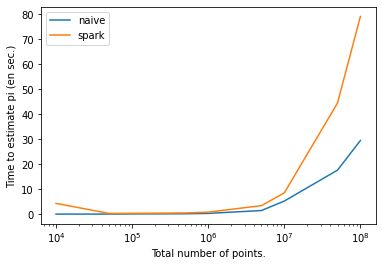

In [4]:
from time import time
import numpy as np
from random import random
from operator import add
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession


def naive_method_time(n):
    inside = 0

    t_0 = time()
    for i in range(n):
        x, y = random(), random()
        if x**2 + y**2 < 1:
            inside += 1
    return(np.round(time()-t_0, 3))


def spark_method_time(n):
    def inside(p):
        # p is useless here
        x, y = random(), random()
        return 1 if x*x + y*y < 1 else 0
    t_0 = time()
    ### create a RDD dataset
    sc.parallelize(range(0, n)) \
        .map(inside).reduce(add)
    return(np.round(time()-t_0, 3))


spark = SparkSession.builder.appName('Calculate Pi').getOrCreate()
sc = spark.sparkContext

N = [10000, 50000, 100000, 500000,
     1000000, 5000000, 10000000, 50000000, 100000000]
T = []
T_spark = []
for n in N:
    T_spark.append(spark_method_time(n))
    T.append(naive_method_time(n))

spark.stop()

plt.plot(N, T, label="naive")
plt.plot(N, T_spark, label="spark")

plt.xscale("log")
plt.xlabel("Total number of points.")
plt.ylabel("Time to estimate pi (en sec.)")
plt.legend()
plt.show()

### Spark is Faster

When using a resilent distributed dataset in this context, it doesn't matter how much or what data is in there -- right now we are just showing that RDDs are faster than a single number.  With the use of an RDD Spark can actually distribute calculations over many machines (or nodes).  That means each node will perform the calculation in parallel.  Hence we split up the calculations, distributed them, and got a speed improvement of nearly five times the naive function.  For a further look at the example above, see the following page, where much of the code it taken from for Spark's first execution of the pi calculation: [Spark Examples](!https://spark.apache.org/examples.html#:~:text=Pi%20estimation,this%20to%20get%20our%20estimate.)

### Other Things to Explore In Spark

- mapper functions
- rdd datasets (resilient distributed dataset) advanced analytics and machine learning
- training across workers

### References

1. Spark cheat sheet: [Spark Cheat Sheet](http://datacamp-community-prod.s3.amazonaws.com/02213cb4-b391-4516-adcd-57243ced8eed)
2. Spark documentation: [Apache Spark](https://spark.apache.org/docs/latest/)
3. Blog Article on Spark: [Article](https://docs.ovh.com/us/en/data-processing/pi-spark/)
